In [2]:
from transformers import DetrImageProcessor
import torch
import cv2
import supervision as sv
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import onnxruntime
from PIL import Image

##### !optimum-cli export onnx --model .\epoch20\ --task object-detection  weight_onnx/    

In [3]:
class DetrObjectDetectionOutput:
    def __init__(self, logits, pred_boxes):
        self.logits = logits
        self.pred_boxes = pred_boxes
    
    def __repr__(self):
        return f"DetrObjectDetectionOutput(logits={self.logits}, pred_boxes={self.pred_boxes})"
id2label = {
    1: "bicycle",
    2: "bus",
    3: "car",
    4: "motorbike",
    5: "person",
    6: "truck",
}
image_processor =DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


TensorrtExecutionProvider, CPUExecutionProvider

## Inference with a image

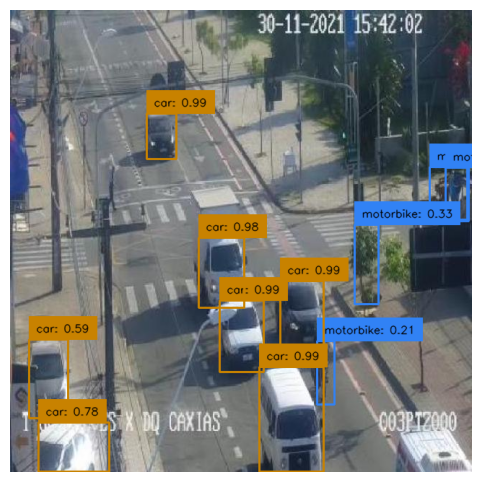

In [4]:

# Load the ONNX model
onnx_model_path = './weights/model.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=[
                    (
                        "TensorrtExecutionProvider",
                        {
                                    'device_id': 0,

                            "trt_fp16_enable": True,
                            "trt_max_workspace_size": 2147483648,
                        },
                    ),
                    "CUDAExecutionProvider",
                ],)# Initialize the camera capture
# Load and preprocess the image
image_path = './img/street.jpg' # Path to your image
image_origin = Image.open(image_path)
image = np.array(image_origin)
image = image.transpose(2, 0, 1)  # Channels-first format (C,H,W)
image = image.astype(np.float32) / 255.0  # Normalize pixel values
# image = image[np.newaxis, :, :, :].astype(np.float32)
image_size = image_origin.size
target_sizes = [[image_size[0], image_size[1]]]
target_sizes_tensor = torch.tensor(target_sizes)

# Run inference
outputs = ort_session.run(None, {ort_session.get_inputs()[0].name: np.expand_dims(image, axis=0)})  # Pass input data

logits_tensor = torch.tensor(outputs[0], dtype=torch.float32)
pred_boxes_tensor = torch.tensor(outputs[1], dtype=torch.float32)
detr_output = DetrObjectDetectionOutput(logits_tensor, pred_boxes_tensor)
results = image_processor.post_process_object_detection(detr_output, target_sizes=target_sizes_tensor, threshold=0.2)[0]
detections = sv.Detections.from_transformers(transformers_results=results)
labels = [f"{id2label[class_id.item()]}: {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
box_annotator = sv.BoxAnnotator()
image_np = np.array(image_origin)
frame_detections = box_annotator.annotate(scene=image_np, detections=detections, labels=labels)

# Plot the annotated image
plt.figure(figsize=(6, 6))  # You can adjust the figure size as needed
plt.imshow(frame_detections)
plt.axis('off')  # Remove axis ticks and labels
plt.show()


## Inference with camera


In [6]:
import cv2
import numpy as np
import onnxruntime
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define your DetrObjectDetectionOutput class and id2label mapping here
class DetrObjectDetectionOutput:
    def __init__(self, logits, pred_boxes):
        self.logits = logits
        self.pred_boxes = pred_boxes
    
    def __repr__(self):
        return f"DetrObjectDetectionOutput(logits={self.logits}, pred_boxes={self.pred_boxes})"

id2label = {
    1: "bicycle",
    2: "bus",
    3: "car",
    4: "motorbike",
    5: "person",
    6: "truck",
}

# Load the ONNX model
onnx_model_path = './weights/model.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=['TensorrtExecutionProvider'])
# Initialize the camera capture
cap = cv2.VideoCapture(0)  # Use 0 for the default camera

# Create an instance of DetrImageProcessor (replace with your own implementation)
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Function to preprocess the image
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (512, 512))  # Resize to match model input size
    image = image.astype(np.float32) / 255.0  # Normalize pixel values
    image = image.transpose(2, 0, 1)  # Channels-first format (C,H,W)
    return image

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame
    image = preprocess_image(frame)

    # Run inference
    start = time.perf_counter()
    outputs = ort_session.run(None, {ort_session.get_inputs()[0].name: np.expand_dims(image, axis=0)})
    print(f"Inference time: {(time.perf_counter() - start)*1000:.2f} ms")
    # Convert outputs to torch tensors
    logits_tensor = torch.tensor(outputs[0])
    pred_boxes_tensor = torch.tensor(outputs[1])

    # Create an instance of DetrObjectDetectionOutput
    detr_output = DetrObjectDetectionOutput(logits_tensor, pred_boxes_tensor)
    
    # Determine the batch size
    batch_size = logits_tensor.shape[0]

    # Generate target sizes for the batch
    target_sizes = [[image.shape[1], image.shape[2]]] * batch_size
    target_sizes_tensor = torch.tensor(target_sizes)

    # Perform post-processing to get detections
    results = image_processor.post_process_object_detection(detr_output, target_sizes=target_sizes_tensor, threshold=0.2)[0]

    # Convert detections to Supervisely format
    detections = sv.Detections.from_transformers(transformers_results=results)

    # Get labels for detections
    labels = [f"{id2label[class_id.item()]}: {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]

    # Annotate the frame with detections and labels
    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

    # Display the annotated frame
    cv2.imshow('Object Detection', annotated_frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()


Inference time: 44383.40 ms
Inference time: 27.96 ms
Inference time: 27.38 ms
Inference time: 24.57 ms
Inference time: 24.89 ms
Inference time: 25.68 ms
Inference time: 25.13 ms
Inference time: 22.31 ms
Inference time: 23.15 ms
Inference time: 22.36 ms
Inference time: 23.58 ms
Inference time: 24.38 ms
Inference time: 22.88 ms
Inference time: 22.22 ms
Inference time: 23.46 ms
Inference time: 21.37 ms
Inference time: 21.01 ms
Inference time: 20.82 ms
Inference time: 20.76 ms
Inference time: 21.28 ms
Inference time: 20.98 ms
Inference time: 21.40 ms
Inference time: 22.59 ms
Inference time: 20.78 ms
Inference time: 21.17 ms
Inference time: 20.94 ms
Inference time: 20.61 ms
Inference time: 20.49 ms
Inference time: 19.20 ms
Inference time: 18.43 ms
Inference time: 20.60 ms
Inference time: 19.72 ms
Inference time: 20.46 ms
Inference time: 19.19 ms
Inference time: 19.66 ms
Inference time: 19.70 ms
Inference time: 20.87 ms
Inference time: 18.84 ms
Inference time: 18.30 ms
Inference time: 19.97 

In [11]:
import onnx
import onnxruntime
from onnxruntime.quantization import quantize_dynamic, QuantType
import numpy as np
# Load the original ONNX model
onnx_model_path = './weights/model.onnx'
# original_model = onnx.load(onnx_model_path)
onnx_model_output = './weights/model_16.onnx'

# Quantize the model to accept float16 inputs
quantized_model = quantize_dynamic(model_input=onnx_model_path, model_output= onnx_model_output)

# # Save the quantized model
# quantized_model_path = 'quantized_model.onnx'
# onnx.save(quantized_model, quantized_model_path)

# # Load the quantized model
# ort_session = onnxruntime.InferenceSession(quantized_model_path)
